In [1]:
!pip install /kaggle/input/rdkit-2025-3-3/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

Processing /kaggle/input/rdkit-2025-3-3/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import gc
import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

import lightgbm as lgb

from sklearn.model_selection import KFold

import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops

In [3]:
class CFG:
    TARGETS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    SEED = 42
    FOLDS = 5
    PATH = '/kaggle/input/neurips-open-polymer-prediction-2025/'

train = pd.read_csv(CFG.PATH + 'train.csv')
test = pd.read_csv(CFG.PATH + 'test.csv')

def make_smile_canonical(smile): # To avoid duplicates, for example: canonical '*C=C(*)C' == '*C(=C*)C'
    try:
        mol = Chem.MolFromSmiles(smile)
        canon_smile = Chem.MolToSmiles(mol, canonical=True)
        return canon_smile
    except:
        return np.nan

train['SMILES'] = train['SMILES'].apply(lambda s: make_smile_canonical(s))
test['SMILES'] = test['SMILES'].apply(lambda s: make_smile_canonical(s))

In [4]:
# https://www.kaggle.com/datasets/minatoyukinaxlisa/tc-smiles
data_tc = pd.read_csv('/kaggle/input/tc-smiles/Tc_SMILES.csv')
data_tc = data_tc.rename(columns={'TC_mean': 'Tc'})

# https://springernature.figshare.com/articles/dataset/dataset_with_glass_transition_temperature/24219958?file=42507037
data_tg2 = pd.read_csv('/kaggle/input/smiles-extra-data/JCIM_sup_bigsmiles.csv', usecols=['SMILES', 'Tg (C)'])
data_tg2 = data_tg2.rename(columns={'Tg (C)': 'Tg'})

# https://www.sciencedirect.com/science/article/pii/S2590159123000377#ec0005
data_tg3 = pd.read_excel('/kaggle/input/smiles-extra-data/data_tg3.xlsx')
data_tg3 = data_tg3.rename(columns={'Tg [K]': 'Tg'})
data_tg3['Tg'] = data_tg3['Tg'] - 273.15

# https://github.com/Duke-MatSci/ChemProps
data_dnst = pd.read_excel('/kaggle/input/smiles-extra-data/data_dnst1.xlsx')
data_dnst = data_dnst.rename(columns={'density(g/cm3)': 'Density'})[['SMILES', 'Density']]
data_dnst['SMILES'] = data_dnst['SMILES'].apply(lambda s: make_smile_canonical(s))
data_dnst = data_dnst[(data_dnst['SMILES'].notnull())&(data_dnst['Density'].notnull())&(data_dnst['Density'] != 'nylon')]
data_dnst['Density'] = data_dnst['Density'].astype('float64')
data_dnst['Density'] -= 0.118

def add_extra_data(df_train, df_extra, target):
    n_samples_before = len(df_train[df_train[target].notnull()])
    
    df_extra['SMILES'] = df_extra['SMILES'].apply(lambda s: make_smile_canonical(s))
    df_extra = df_extra.groupby('SMILES', as_index=False)[target].mean()
    cross_smiles = set(df_extra['SMILES']) & set(df_train['SMILES'])
    unique_smiles_extra = set(df_extra['SMILES']) - set(df_train['SMILES'])

    # Make priority target value from competition's df
    for smile in df_train[df_train[target].notnull()]['SMILES'].tolist():
        if smile in cross_smiles:
            cross_smiles.remove(smile)

    # Imput missing values for competition's SMILES
    for smile in cross_smiles:
        df_train.loc[df_train['SMILES']==smile, target] = df_extra[df_extra['SMILES']==smile][target].values[0]
    
    df_train = pd.concat([df_train, df_extra[df_extra['SMILES'].isin(unique_smiles_extra)]], axis=0).reset_index(drop=True)

    n_samples_after = len(df_train[df_train[target].notnull()])
    print(f'\nFor target "{target}" added {n_samples_after-n_samples_before} new samples!')
    print(f'New unique SMILES: {len(unique_smiles_extra)}')
    return df_train

train = add_extra_data(train, data_tc, 'Tc')
train = add_extra_data(train, data_tg2, 'Tg')
train = add_extra_data(train, data_tg3, 'Tg')
train = add_extra_data(train, data_dnst, 'Density')

print('\n'*3, '--- SMILES for training ---', )
for t in CFG.TARGETS:
    print(f'"{t}": {len(train[train[t].notnull()])}')

[14:43:29] SMILES Parse Error: syntax error while parsing: *O[Si](*)([R])[R]
[14:43:29] SMILES Parse Error: check for mistakes around position 12:
[14:43:29] *O[Si](*)([R])[R]
[14:43:29] ~~~~~~~~~~~^
[14:43:29] SMILES Parse Error: Failed parsing SMILES '*O[Si](*)([R])[R]' for input: '*O[Si](*)([R])[R]'
[14:43:29] SMILES Parse Error: syntax error while parsing: *NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4
[14:43:29] SMILES Parse Error: check for mistakes around position 28:
[14:43:29] c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=
[14:43:29] ~~~~~~~~~~~~~~~~~~~~^
[14:43:29] SMILES Parse Error: Failed parsing SMILES '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4' for input: '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4'
[14:43:29] SMILES Parse Error: syntax error while parsing: O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[14:43:29] SMILES Parse Error: check for mistakes around position 7:
[14:43:29] O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[14:43:29] ~~~~~~^
[14:43:29] SMILES Parse Error: F


For target "Tc" added 129 new samples!
New unique SMILES: 129

For target "Tg" added 151 new samples!
New unique SMILES: 136

For target "Tg" added 499 new samples!
New unique SMILES: 499

For target "Density" added 634 new samples!
New unique SMILES: 524



 --- SMILES for training ---
"Tg": 1161
"FFV": 7030
"Tc": 866
"Density": 1247
"Rg": 614


In [5]:
useless_cols = [    
    # Nan data
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',

    # Constant data
    'NumRadicalElectrons',
    'SMR_VSA8',
    'SlogP_VSA9',
    'fr_barbitur',
    'fr_benzodiazepine',
    'fr_dihydropyridine',
    'fr_epoxide',
    'fr_isothiocyan',
    'fr_lactam',
    'fr_nitroso',
    'fr_prisulfonamd',
    'fr_thiocyan',

    # High correlated data >0.95
    'MaxEStateIndex',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumValenceElectrons',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Kappa1',
    'LabuteASA',
    'HeavyAtomCount',
    'MolMR',
    'Chi3n',
    'BertzCT',
    'Chi2v',
    'Chi4n',
    'HallKierAlpha',
    'Chi3v',
    'Chi4v',
    'MinAbsPartialCharge',
    'MinPartialCharge',
    'MaxAbsPartialCharge',
    'FpDensityMorgan2',
    'FpDensityMorgan3',
    'Phi',
    'Kappa3',
    'fr_nitrile',
    'SlogP_VSA6',
    'NumAromaticCarbocycles',
    'NumAromaticRings',
    'fr_benzene',
    'VSA_EState6',
    'NOCount',
    'fr_C_O',
    'fr_C_O_noCOO',
    'NumHDonors',
    'fr_amide',
    'fr_Nhpyrrole',
    'fr_phenol',
    'fr_phenol_noOrthoHbond',
    'fr_COO2',
    'fr_halogen',
    'fr_diazo',
    'fr_nitro_arom',
    'fr_phos_ester'
]

def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList if desc[0] not in useless_cols]

def compute_graph_features(smiles, graph_feats):
    mol = Chem.MolFromSmiles(smiles)
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)

    graph_feats['graph_diameter'].append(nx.diameter(G) if nx.is_connected(G) else 0)
    graph_feats['avg_shortest_path'].append(nx.average_shortest_path_length(G) if nx.is_connected(G) else 0)
    graph_feats['num_cycles'].append(len(list(nx.cycle_basis(G))))

def preprocessing(df):
    desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]
    descriptors = [compute_all_descriptors(smi) for smi in df['SMILES'].to_list()]

    graph_feats = {'graph_diameter': [], 'avg_shortest_path': [], 'num_cycles': []}
    for smile in df['SMILES']:
         compute_graph_features(smile, graph_feats)
        
    result = pd.concat(
        [
            pd.DataFrame(descriptors, columns=desc_names),
            pd.DataFrame(graph_feats)
        ],
        axis=1
    )

    result = result.replace([-np.inf, np.inf], np.nan)
    return result

train = pd.concat([train, preprocessing(train)], axis=1)
test = pd.concat([test, preprocessing(test)], axis=1)

# Find constant columns for each target
all_features = train.columns[7:].tolist()
features = {}
for target in CFG.TARGETS:
    const_descs = []
    for col in train.columns.drop(CFG.TARGETS):
        if train[train[target].notnull()][col].nunique() == 1:
            const_descs.append(col)
    features[target] = [f for f in all_features if f not in const_descs]

In [6]:
def mae(y_true, y_pred):
    return sum(abs(true - pred) for true, pred in zip(y_true, y_pred)) / len(y_true)

base_params = {
    'device_type': 'cpu',
    'n_estimators': 1_000_000,
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbosity': -1,
    
    'num_leaves': 50,
    'min_data_in_leaf': 2,
    'learning_rate': 0.01,
    'max_bin': 500,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'lambda_l1': 2,
    'lambda_l2': 2,
}

for target in CFG.TARGETS:
    print(f'\n\nTARGET {target}')
    train_part = train[train[target].notnull()].reset_index(drop=True)
    train[f'{target}_pred'] = 0
    test[target] = 0
    oof_lgb = np.zeros(len(train_part))
    scores = []
    
    kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
        print(f"\n--- Fold {i+1} ---")
        
        x_trn = train_part.loc[trn_idx, features[target]]
        y_trn = train_part.loc[trn_idx, target]
        x_val = train_part.loc[val_idx, features[target]]
        y_val = train_part.loc[val_idx, target]

        model_lgb = lgb.LGBMRegressor(**base_params)
        model_lgb.fit(
            x_trn, y_trn,
            eval_set=[(x_val, y_val)],
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=300,
                    verbose=False,
                ),
                lgb.log_evaluation(2500)
            ],
        )

        with open(f'/kaggle/working/lgb_{target}_fold_{i}.pkl', 'wb') as f:
            pickle.dump(model_lgb, f)

        val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
        score = mae(y_val, val_preds)
        scores.append(score)
        print(f'MAE: {np.round(score, 5)}')
        
        oof_lgb[val_idx] = val_preds
        test[target] += model_lgb.predict(
            test[features[target]], 
            num_iteration=model_lgb.best_iteration_
        ) / CFG.FOLDS

    train.loc[train[target].notnull(), f'{target}_pred'] = oof_lgb

    print(f'\nMean MAE: {np.round(np.mean(scores), 5)}')
    print(f'Std MAE: {np.round(np.std(scores), 5)}')
    print('-'*30)



TARGET Tg

--- Fold 1 ---
MAE: 37.07422

--- Fold 2 ---
MAE: 35.06102

--- Fold 3 ---
MAE: 34.76326

--- Fold 4 ---
MAE: 37.77213

--- Fold 5 ---
[2500]	valid_0's l1: 38.1203
MAE: 38.08498

Mean MAE: 36.55112
Std MAE: 1.38087
------------------------------


TARGET FFV

--- Fold 1 ---
[2500]	valid_0's l1: 0.00711121
[5000]	valid_0's l1: 0.00678467
[7500]	valid_0's l1: 0.00661878
[10000]	valid_0's l1: 0.00656755
[12500]	valid_0's l1: 0.00654046
[15000]	valid_0's l1: 0.00651876
[17500]	valid_0's l1: 0.00649841
[20000]	valid_0's l1: 0.00648023
[22500]	valid_0's l1: 0.00646942
[25000]	valid_0's l1: 0.00645859
[27500]	valid_0's l1: 0.00644966
[30000]	valid_0's l1: 0.00644029
MAE: 0.00643

--- Fold 2 ---
[2500]	valid_0's l1: 0.00663597
[5000]	valid_0's l1: 0.00631825
[7500]	valid_0's l1: 0.00620641
[10000]	valid_0's l1: 0.00615943
[12500]	valid_0's l1: 0.00614095
[15000]	valid_0's l1: 0.00612347
[17500]	valid_0's l1: 0.00610858
[20000]	valid_0's l1: 0.00609783
MAE: 0.0061

--- Fold 3 ---
[

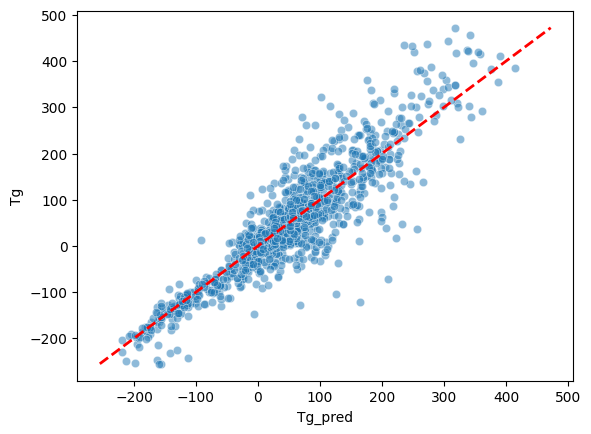

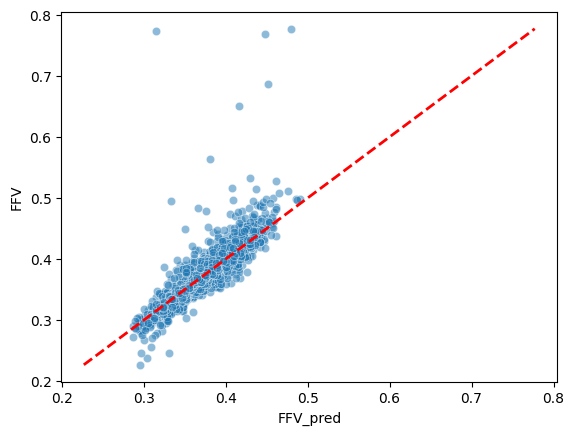

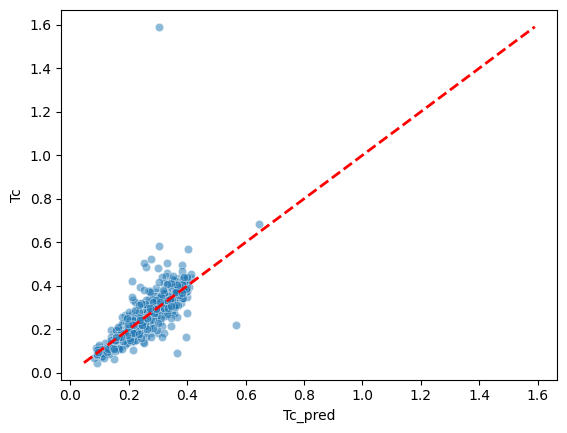

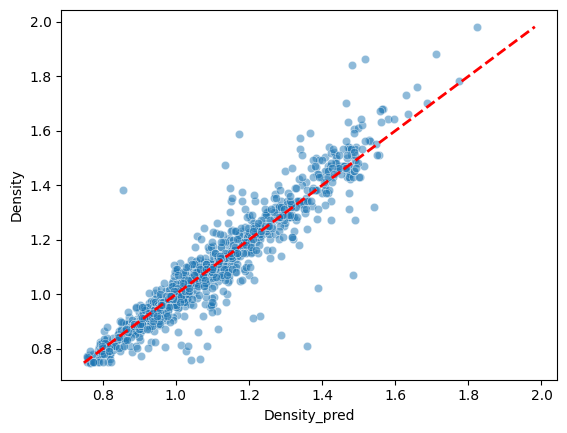

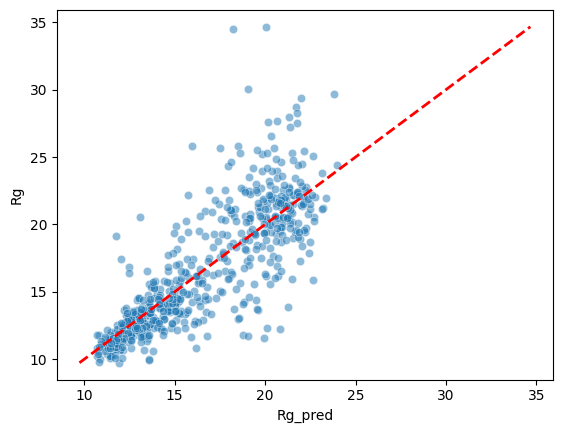

In [7]:
for t in CFG.TARGETS:
    preds = train[train[t].notnull()][f'{t}_pred']
    vals = train[train[t].notnull()][t]
    line_min = min(preds.min(), vals.min())
    line_max = max(preds.max(), vals.max())
    
    sns.scatterplot(x=preds, y=vals, alpha=0.5)
    plt.plot(
        [line_min, line_max], 
        [line_min, line_max], 
        color='red', 
        linewidth=2, 
        linestyle='dashed'
    )
    plt.show()

In [8]:
MINMAX_DICT =  {
        'Tg': [-148.0297376, 472.25],
        'FFV': [0.2269924, 0.77709707],
        'Tc': [0.0465, 0.524],
        'Density': [0.748691234, 1.840998909],
        'Rg': [9.7283551, 34.672905605],
    }
NULL_FOR_SUBMISSION = -9999

def scaling_error(labels, preds, property):
    error = np.abs(labels - preds)
    min_val, max_val = MINMAX_DICT[property]
    label_range = max_val - min_val
    return np.mean(error / label_range)

def get_property_weights(labels):
    property_weight = []
    for property in MINMAX_DICT.keys():
        valid_num = np.sum(labels[property] != NULL_FOR_SUBMISSION)
        property_weight.append(valid_num)
    property_weight = np.array(property_weight)
    property_weight = np.sqrt(1 / property_weight)
    return (property_weight / np.sum(property_weight)) * len(property_weight)

def wmae_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    chemical_properties = list(MINMAX_DICT.keys())
    property_maes = []
    property_weights = get_property_weights(solution[chemical_properties])
    for property in chemical_properties:
        is_labeled = solution[property] != NULL_FOR_SUBMISSION
        property_maes.append(scaling_error(solution.loc[is_labeled, property], submission.loc[is_labeled, property], property))

    if len(property_maes) == 0:
        raise RuntimeError('No labels')
    return float(np.average(property_maes, weights=property_weights))

tr_solution = train[['id'] + CFG.TARGETS]
tr_submission = train[['id'] + [t + '_pred' for t in CFG.TARGETS]]
tr_submission.columns = ['id'] + CFG.TARGETS
print(f"wMAE: {round(wmae_score(tr_solution, tr_submission, row_id_column_name='id'), 5)}")

wMAE: 0.04789


**If you don't use a direct check for the presence of SMILES in the test data from external data, the LB result will be `0.47`**

In [9]:
for t in CFG.TARGETS:
    for s in train[train[t].notnull()]['SMILES']:
        if s in test['SMILES'].tolist():
            test.loc[test['SMILES']==s, t] = train[train['SMILES']==s][t].values[0]

I'm rather disappointed that we are faced with the following situation, that test data contains data from publicly available sources is terrible. Also only the organizer can determine exactly where there is a license and where there is not. I'm not particularly interested in the cash prize, and I would like to make a good solution, but with only organizer's data it is difficult. I hope that the situation with the data used will become clearer.

In [10]:
test[['id'] + CFG.TARGETS].to_csv('submission.csv', index=False)